In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('halong_quality.csv')
df1=df.reset_index()['pm25']

In [3]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5  # You can adjust the window size as needed
    data_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    data_smoothed_interpolated = data_smoothed.interpolate()

    # Fill remaining NaN values
    data_smoothed_filled = data_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)

    return data_smoothed_filled

In [4]:
df1= smoothed(df1)
print(df1)

0       36.6
1       36.6
2       36.6
3       36.6
4       36.6
        ... 
1915    53.0
1916    49.0
1917    51.8
1918    51.0
1919    40.0
Name: pm25, Length: 1920, dtype: float64


In [5]:
df1.shape

(1920,)

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [8]:
print(train_size)
print(test_size)

1728
192


In [9]:
print(train_data.shape)
print(test_data.shape)


(1728, 1)
(192, 1)


In [10]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)


(1627, 100)
(1627,)
(91, 100)
(91,)


In [13]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [14]:
print(X_train.shape)
print(X_test.shape)

(1627, 100, 1)
(91, 100, 1)


In [15]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0347
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0064
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0039
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0030
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0023
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0022
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0020
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0019
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0015
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - l

In [17]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  


In [18]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [19]:
y_pred = pd.DataFrame(y_pred, columns=['pm25'])
y_pred = smoothed(y_pred)
y_pred = y_pred.to_numpy()

In [20]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 13.584221838354456
Testing MAPE: 28.237473172635646
Testing MAE: 12.080338410536449


In [21]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 132)

In [22]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


(1, 132)
[0.24651882]
133
1 day input [0.17275748 0.14784053 0.19435216 0.26744186 0.35049834 0.3538206
 0.4269103  0.40863787 0.31561462 0.25581395 0.20431894 0.25083056
 0.2358804  0.30398671 0.30232558 0.33056478 0.28737542 0.29568106
 0.31229236 0.31395349 0.32392027 0.34551495 0.3538206  0.27076412
 0.27242525 0.19767442 0.16445183 0.12624585 0.20598007 0.23920266
 0.25415282 0.18936877 0.26910299 0.2358804  0.22757475 0.24086379
 0.29734219 0.28405316 0.2358804  0.21594684 0.28571429 0.32392027
 0.29401993 0.38039867 0.42358804 0.39202658 0.29734219 0.34053156
 0.3372093  0.31063123 0.24584718 0.30564784 0.30066445 0.31893688
 0.27906977 0.34717608 0.35049834 0.29734219 0.20099668 0.24916944
 0.17607973 0.18936877 0.20598007 0.25747508 0.27408638 0.36710963
 0.35880399 0.35215947 0.35049834 0.32059801 0.28239203 0.26744186
 0.25747508 0.27076412 0.29069767 0.29900332 0.27740864 0.26910299
 0.25747508 0.23754153 0.23421927 0.25083056 0.25747508 0.24916944
 0.24086379 0.23255814 0.

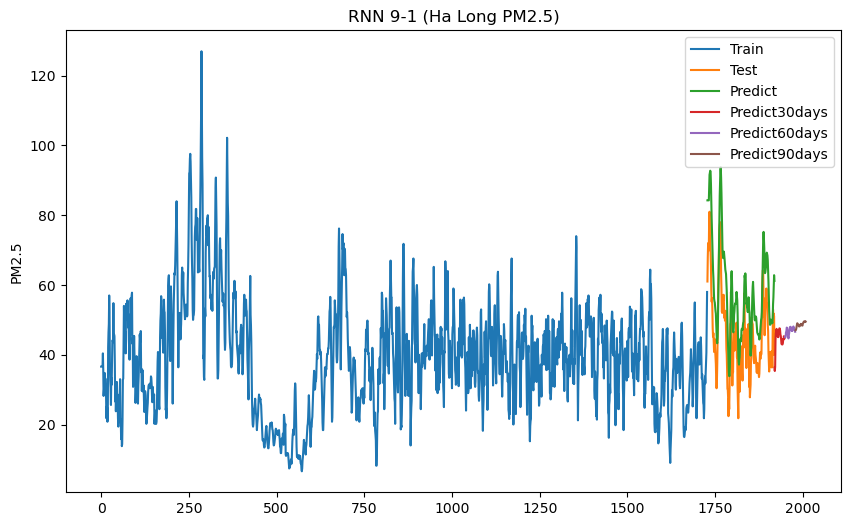

In [23]:
# Define the indices
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot train data
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plot test data and predictions
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred, label='Predict')

# Plot predictions for future data in 30-day intervals
for i in range(3):
    start_idx = len(df1) + (i * 30) - 1
    end_idx = start_idx + 30
    plt.plot(pd.RangeIndex(start=start_idx, stop=end_idx, step=1),
             scaler.inverse_transform(lst_output[i*30:(i+1)*30]),
             label=f'Predict{i*30+30}days')

# Add legend and labels
plt.legend()
plt.title('RNN 9-1 (Ha Long PM2.5)')
plt.ylabel('PM2.5')
plt.show()

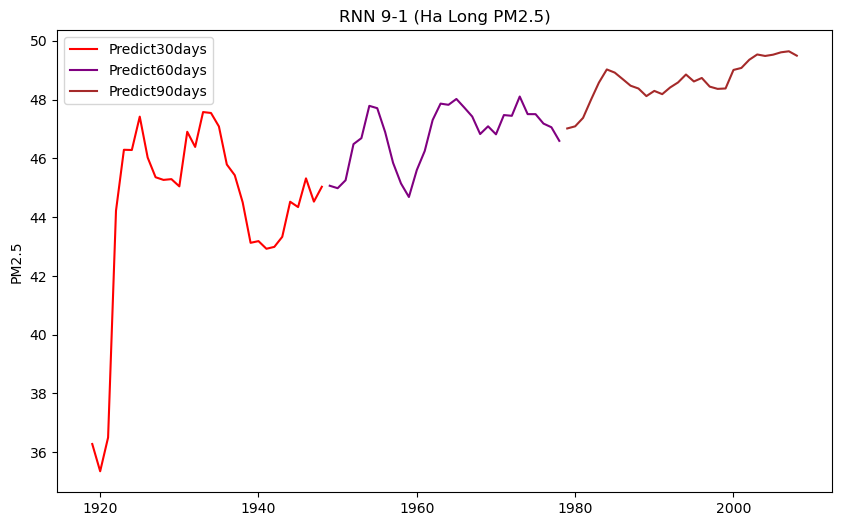

In [24]:
plt.figure(figsize=(10, 6))

# Plot predictions for future data in 30-day intervals with specified colors
colors = ['red', 'purple', 'brown']
for i in range(3):
    start_idx = len(df1) + (i * 30) - 1
    end_idx = start_idx + 30
    plt.plot(pd.RangeIndex(start=start_idx, stop=end_idx, step=1),
             scaler.inverse_transform(lst_output[i*30:(i+1)*30]),
             label=f'Predict{i*30+30}days',
             color=colors[i])

# Add legend and labels
plt.legend()
plt.title('RNN 9-1 (Ha Long PM2.5)')
plt.ylabel('PM2.5')
plt.show()